<a href="https://colab.research.google.com/github/SmartSoundKAIST/KSNVE2022AISummer/main/3_Anomaly_Detection_(Reconstruction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022년 인공지능 강습회 2일차 실습 코드**
## **Practice 1 : Introduction to Anomaly Detection (Reconstruction)**

Anomaly detection can be done by various pretext tasks. In this session, we will do anomaly detection using reconstruction as a pretext task on the MNIST dataset. 💻



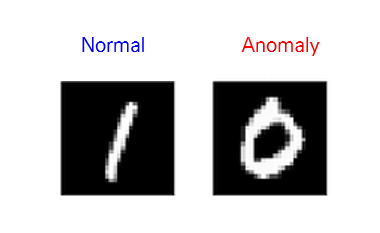

## 1. Import packages
New library imported for this project: 
- `Scikit-learn` package: includes useful tools for data analysis & preprocessing (https://scikit-learn.org/stable/)
  - We use this package for `anomaly score` metrics
- `Matplot` library: for plotting graphs
- `Torchinfo`: summarizes and print formatted `model information` 

In [ ]:
!pip install torchinfo                                                          # install torchinfo module 
import torch
from torch import nn
from torchvision import datasets                                                # https://pytorch.org/vision/stable/datasets.html
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn import metrics                                                     # for Anomaly scores (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
import matplotlib.pyplot as plt                                                 # for plotting (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html)
from torchinfo import summary                                                   # for model summary (https://github.com/TylerYep/torchinfo)
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'                         # use gpu if available
print(f'Using {device} device')

In [ ]:
plt.rc('font', size=20)                                                         # set the pyplot object with given property (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.rc.html)

## 2. Hyperparameters
You can change the hyperparameter below.
Parameter `ANOMALY_NUM` means which number to set as an anomaly.

In [ ]:
EPOCHS = 5                                                                      # Number of epochs to train
BATCH = 32                                                                      # Minibatch size
ANOMALY_NUM = [0]                                                               # (list) Data of digit "0" will be used as anomalous data
NORMAL_NUM =  [1]                                                               # (list) Data of digit "1" will be used as normal data  

The dataset for anomaly detection is composed of normal data and anomaly data. Normal data can be seen in the train, validation, and test dataset, but anomaly data is not in the train dataset. Here digit `1` will be used as `normal data`, and `0` will be used as `anomaly data`. 

## 3. Dataset and Dataloader

Here we use MNIST dataset. 
The datatype of the dataset is a TorchTensor of tuples: (`image tensor`, `target label`)

The dimensions of an image tensor is (`channel`=1, `width`=28, `height` =28)

Here, we use `Subset` package in `torch.utils.data` to build two sub-datasets (validation, test).

MNIST dataset: https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

In [ ]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test  = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)


In [ ]:
train_idx = [i for i,v in enumerate(mnist_train) if v[1] in NORMAL_NUM]         # get a list of indices with NORMAL_NUM, v is the tuple of (image tensor, label)
train_dataset = Subset(mnist_train,train_idx)                                   # get a subset of dataset using train_idx
                                     
testdigit = ANOMALY_NUM + NORMAL_NUM                                            # join two list
test_idx =[i for i,v in enumerate(mnist_test) if v[1] in testdigit]
Num_test = int(len(test_idx)/2);

test_dataset = Subset(mnist_test,test_idx[:Num_test])
val_dataset = Subset(mnist_test,test_idx[Num_test:])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

Dataset length is like below.

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

## 4. Define a DNN model 
We will use a simple autoencoder for practice.

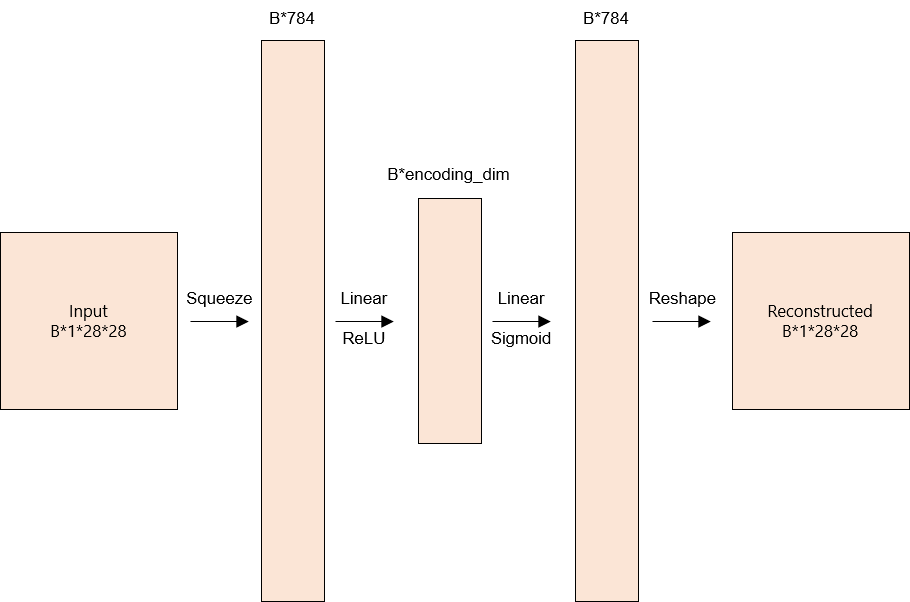

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, self.encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.encoder(out)
        out = self.decoder(out)
        out = out.view(x.size())
        return out

In [ ]:
model = AutoEncoder(64).to(device)
summary(model,input_size=(BATCH,1,28,28))                                       # summary(model, input_size)

### 4-1. Loss functions & optimizers

Loss function and anomaly score are the same MSE between input and reconstructed images. However, we use the option `reduction='none'` for the anomaly score. This flag turn off the average over samples, so we can get MSE values of individual images. 

In [ ]:
loss_fn = nn.MSELoss()                                                          # create MSE loss object (default reduction: 'mean')
anomaly_score = nn.MSELoss(reduction='none')                                    # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 5. Train & Test classes
The design of train & test classes is quite similar to previous examples. 

### 5-1. Define Train function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()                                                               # turn on the train mode

    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        X = X[0].to(device)                                                     # change to tensor data type adequate for the current device 
        pred = model(X)                                                         # make prediction from a model
        loss = loss_fn(pred, X)                                                 # calculate loss function

        for idata in range(pred.shape[0]):
            iloss = loss_fn(pred[idata,:,:], X[idata,:,:])
            losses.append(iloss)                                                # build losses matrix for individual samples   (BATCH)              

        optimizer.zero_grad()                                                   # init gradient in optimizer
        loss.backward()                                                         # calculate gradient
        optimizer.step()                                                        # gradient descent

        if batch % 300 == 0:                                                    # display progress for every 300 minibatches              
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    losses = [i.item() for i in losses]                                         # convert the tensor losses to a list
    return np.mean(losses)

Anomaly score is calculated over validation and test datasets. Since the model is trained with normal data, the model may not reconstruct anomaly data well, so the anomaly score of anomaly data will be higher than the anomaly score of normal data. Using difference in anomaly score distributions, ROC-AUC (Area Under Curve) can be calculated.

### 5-2. Define Test function

Evaluate the model and plot results

In [ ]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()                                                                # turn on the evaluation mode

    y_true, y_pred = [], []
    normal_loss = []                                                            # separately calculate losses for normal and abnormal data
    anomaly_loss = []

    with torch.no_grad():                                                       # turn-off the gradient tracker   
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)                                   # send to GPU or CPU
            output = model(X)                                                   # (BATCH,CH,H,W)

            for idata in range(output.shape[0]):                                # output from the model is a tensor of information
                loss = loss_fn(output[idata,:,:], X[idata,:,:])
                if y[idata] in NORMAL_NUM:
                    y[idata] = 0                                                # replace original digit label (number) to 0 and 1 (anomality)
                    normal_loss.append(loss)
                elif y[idata] in ANOMALY_NUM:
                    y[idata] = 1
                    anomaly_loss.append(loss)
            
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))             # average in (CH,H,W) dims

            y_true.extend(y.tolist())                                           # torchtensor -> list and extend to list y_true
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(5,5))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')

    print(f'ROC AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    anomaly_loss = [i.item() for i in anomaly_loss]
    normal_loss_mean = np.mean(normal_loss)
    anomaly_loss_mean = np.mean(anomaly_loss)
    print(f'normal loss : {normal_loss_mean}')
    print(f'anomaly loss : {anomaly_loss_mean}')
    return roc_auc.item(), normal_loss_mean, anomaly_loss_mean, normal_loss, anomaly_loss

## 6. Run Trainer 
Now all the classes are defined. Let's see how reconstruction loss and AUC changes during training.

Loss is calculated during train, and AUC is calculated during validation.

In [ ]:
aucs = []
train_normal_losses = []
val_normal_losses = []
val_anomaly_losses = []
best_auc = 0
best_model = model.to(device)                                                   # allocate model to GPU or CPU

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_normal_loss = train(train_dataloader, model, loss_fn, optimizer)      # train for single epoch
    auc, val_normal_loss, val_anomaly_loss, _, _ = test(val_dataloader, model, loss_fn, anomaly_score)      # validation for single epoch

    train_normal_losses.append(train_normal_loss)
    aucs.append(auc)
    val_normal_losses.append(val_normal_loss)
    val_anomaly_losses.append(val_anomaly_loss)
    if best_auc < auc:                                                          # as num of epoch increases, store the best model (based on AUC)
      best_model = model
      best_auc = auc

### 6-1. Plot train results

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(aucs)+1)),aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_normal_losses)+1)),train_normal_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'], fontsize=10)

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.plot(list(range(1,len(val_anomaly_losses)+1)),val_anomaly_losses)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal','validation anomaly'], fontsize=10)

## 7. Performance on test data.

### 7-1. ROC-AUC

In [ ]:
auc, _, _, test_normal_score, test_anomaly_score = test(test_dataloader, best_model, loss_fn, anomaly_score, True)

### 7-2. Histogram of anomaly score 

In [ ]:
plt.hist(test_normal_score, alpha = 0.8)
plt.hist(test_anomaly_score, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'], fontsize=10)
plt.figure(figsize=(10,10))

=============================================================================

### 7-3. Analysis (Confusion Matrix, Decision Boundary, ROC-AUC)
How can we actually get metrics like TPR, FPR from the result?


In [ ]:
print(len(test_normal_score))
print(len(test_anomaly_score))

First, let's set a decision boundary and make a confusion matrix.

In [ ]:
thres = 0.05                                                                    # decision boundary

P = len(test_anomaly_score)
N = len(test_normal_score)

test_normal_score_np = np.array(test_normal_score)
test_anomaly_score_np = np.array(test_anomaly_score)

is_normal_anomalous = test_normal_score_np > thres
is_anomaly_anomalous = test_anomaly_score_np > thres

TP = is_anomaly_anomalous.sum()
FN = P - TP
FP = is_normal_anomalous.sum()
TN = N - FP

#print(f'TP : {TP} FN : {FN} FP : {FP} TN : {TN}')
import tabulate
table = [[' Actual/Pred', 'P', 'N'],['P',f'TP:{TP}',f'FN:{FN}'],['N',f'FP:{FP}',f'TN:{TN}']]
print('confusion matrix')
print(tabulate.tabulate(table, headers = 'firstrow', tablefmt = 'grid'))


Now let's calculate TPR, FPR. Also let's calculate precision, recall and f1 score.

In [ ]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1 = 2/(1/Precision+1/Recall)
print(f'TPR: {TPR}, FPR: {FPR}, precision: {Precision}, recall: {Recall}, F1: {F1}')

Change `threshold` and check how each value changes.

The next code block manually calcuates ROC-AUC by moving the decision boundary. 
You can compare this result with the previous ROC-AUC curve obtained by *metric* package.

In [ ]:
P = len(test_anomaly_score)
N = len(test_normal_score)

test_normal_score_np = np.array(test_normal_score)
test_anomaly_score_np = np.array(test_anomaly_score)

max_val = np.max([np.max(test_normal_score_np), np.max(test_anomaly_score_np)])

thres = np.linspace(0,max_val,num=1000)

TPR_list = []
FPR_list = []

for ithres in thres:
  is_normal_anomalous = test_normal_score_np > ithres
  is_anomaly_anomalous = test_anomaly_score_np > ithres

  TP = is_anomaly_anomalous.sum()
  FN = P - TP
  FP = is_normal_anomalous.sum()
  TN = N - FP

  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)

  TPR_list.append(TPR)
  FPR_list.append(FPR)


plt.figure(figsize=(5,5))
plt.plot(FPR_list,TPR_list)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

AUC = np.trapz(np.flip(np.array(TPR_list)).tolist(),np.flip(np.array(FPR_list)).tolist())
print(f'ROC AUC : {AUC}')

## 8. Image comparison 

Below code plots figure of the original input image and reconstructed image.

In [ ]:
# plt.rc('font', size=20)
n = 7                              # num of data to plot
plt.figure(figsize=(3*n, 8))


for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = best_model(input_image.unsqueeze(0))
  error_image = torch.abs(input_image[0]-output_image[0])
  
  ax = plt.subplot(3, n, i+1 )
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, n + i + 1)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, 2*n + i + 1)
  plt.imshow(error_image.squeeze().detach().cpu())
  plt.title('error')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

As you can see, normal data (1) is reconstructed well compared to anomaly data (0). 

The normal data have lower reconstruction errors (anomaly score), and anomaly data have higher reconstruction errors.

Using this difference in anomaly score, anomaly detection can be done.